In [ ]:
# Используя разработанный на семинаре код нами код, проиллюстрируйте разброс классов, присутствующих в ImageNet.

In [29]:
import os
import sys
import json
import torch
import pandas as pd

In [2]:
from deeppavlov.core.common.file import read_json
from deeppavlov import build_model, configs

In [9]:
# В штатной поставке модели cased_L-12_H-768_A-12 скачанной отсюда http://files.deeppavlov.ai/deeppavlov_data/bert/cased_L-12_H-768_A-12.zip.
# нет файла pytorch_model.bin 
# без файла pytorch_model.bin возникает исключение в строке
# model = build_model( bert_config )
# Его нужно сформировать командой 
# transformers-cli convert --model_type bert \
#   --tf_checkpoint $BERT_BASE_DIR/model.ckpt \
#   --config $BERT_BASE_DIR/config.json \
#   --pytorch_dump_output $BERT_BASE_DIR/pytorch_model.bin
# как указано здесь: https://stackoverflow.com/questions/62961627/oserror-error-no-file-named-pytorch-model-bin-tf-model-h5-model-ckpt-in

bert_config = read_json( configs.embedder.bert_embedder )
bert_config['metadata']['variables']['BERT_PATH'] = './cased_L-12_H-768_A-12'
model = build_model( bert_config )

In [10]:
tokens, token_embs, subtokens, \
    subtoken_embs, sent_max_embs, \
    sent_mean_embs, bert_pooler_outputs = model(['Publish news about the product.'])

print('tokens:', tokens)
print('token_embs:', token_embs[0].shape)
print('subtokens:', subtokens)
print('subtoken_embs:', subtoken_embs[0].shape)
print('sent_max_embs:', sent_max_embs.shape)
print('sent_mean_embs:', sent_mean_embs.shape)
print('bert_pooler_outputs:', bert_pooler_outputs.shape)

tokens: [['Publish', 'news', 'about', 'the', 'product', '.']]
token_embs: (6, 768)
subtokens: [['[CLS]', 'Pub', '##lish', 'news', 'about', 'the', 'product', '.', '[SEP]']]
subtoken_embs: (9, 768)
sent_max_embs: (1, 768)
sent_mean_embs: (1, 768)
bert_pooler_outputs: (1, 768)


In [26]:
imagenet_labels_file = './imagenet_labels.json'
if not ("IMAGENET_LABELS" in locals() and len(IMAGENET_LABELS) == 1000):
    with open(imagenet_labels_file, 'r') as f:
        IMAGENET_LABELS = json.load(f)
IMAGENET_LABELS_list = list(IMAGENET_LABELS.values())
IMAGENET_LABELS_list[0]

'tench, Tinca tinca'

In [13]:
import torch
from scipy import spatial
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def get_sentence_embedding( sentence ):
    bert_answer = model([sentence])
    embedding = bert_answer[4]
    return embedding


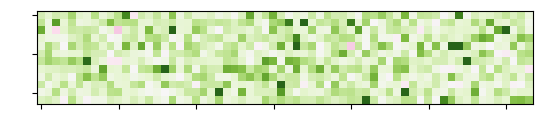

In [21]:
# отобразим ембеддинг для первого элемента словаря IMAGENET_LABELS
sentence = IMAGENET_LABELS_list[0]
plt.imshow(get_sentence_embedding(sentence).reshape(12,-1), \
           cm.PiYG, clim=(-2, 2) ); plt.xticks(color='w'); plt.yticks(color='w');

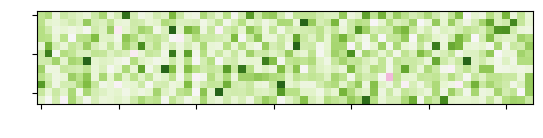

In [27]:
sentence = IMAGENET_LABELS_list[1]
plt.imshow(get_sentence_embedding(sentence).reshape(12,-1), \
           cm.PiYG, clim=(-2, 2) ); plt.xticks(color='w'); plt.yticks(color='w');

In [30]:
# Создайте матрицу эмбеддингов, где будут значения для каждого названия класса.
# Поместите в переменную `embeddings_imagenet`
embeddings_imagenet = np.concatenate([ np.array(get_sentence_embedding(s)) for s in IMAGENET_LABELS_list], axis=0 )

In [34]:
from sklearn.decomposition import PCA
pca = PCA( n_components=15, random_state=42 )
emb_15d = pca.fit_transform( embeddings_imagenet )

In [35]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering( n_clusters=len(IMAGENET_LABELS_list), distance_threshold=None,
                                      affinity='cosine', linkage='average').fit(emb_15d)

In [36]:
# Создайте еще одно разбиение `emb_2d` (полностью по аналогии с прошлыми действиями), но теперь для матрицы `embeddings_imagenet`.
pca = PCA( n_components=2, random_state=42 )
emb_2d = pd.DataFrame( pca.fit_transform(embeddings_imagenet), columns=['x1', 'x2'])
emb_2d['color'] = list(map(int, IMAGENET_LABELS.keys()))
emb_2d['label'] = IMAGENET_LABELS_list

In [37]:
import plotly.express as px
fig = px.scatter( emb_2d, x='x1', y='x2', color='color', width=800, height=600, \
                  color_continuous_scale="Bluered_r", hover_name="label" )
fig.show()

In [ ]:
## Выполнить после задания: Получится ли у нас график укрупненных групп Imagenet?
# Добавим в нашу Pandas-таблицу несколько столбцов.

# - **Короткое название:** _мы его быстро сконструируем из названий в списке_ `IMAGENET_LABELS`_, отрезав все что находится после первой запятой_
# - **Класс:** преобразуем отметку кластера `clustering.labels_` в строку (`.astype(str)`), чтобы получить дискретную шкалу

# Потом узнаем, сколько классов в нашей модели.

In [38]:
emb_2d["short_name"] = [ s.split(",")[0] for s in IMAGENET_LABELS_list ]
emb_2d['color'] = clustering.labels_.astype(str)
emb_2d['color'].nunique()

1000

In [39]:
import plotly.express as px

fig = px.scatter( emb_2d, x='x1', y='x2', color='color',
                  hover_name="short_name", width=800, height=600)

fig.show()